In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import sys
import torch

Williams

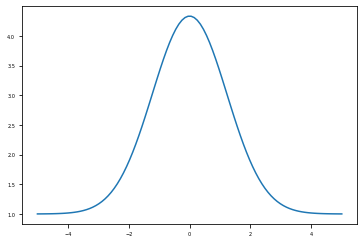

In [92]:
def cov_rbfn(x1, x2, sig2b=1., sig2w=1., sig2c=1., sig2s=1., K=10):
    
    # sig2g in williams is sig2s in our paper
    # sig2u in williams is sig2c in our paper
    # sig2v is willaims is sig2w in our paper
    
    sig2g = sig2s
    sig2u = sig2c
    sig2v = sig2w
    
    sig2e = 1/(2/sig2g + 1/sig2u)
    sig2s = 2*sig2g + sig2g**2/sig2u
    sig2m = 2*sig2u + sig2g
    
    V = sig2e / sig2u * np.exp(-0.5*x1**2/sig2m) * \
                      np.exp(-0.5*(x1-x2)**2/sig2s) * \
                      np.exp(-0.5*x2**2/sig2m)
    
    return sig2b + sig2v*K*V

x = np.linspace(-5,5,100)
plt.plot(x, cov_rbfn(x, x))

PP-RBFN

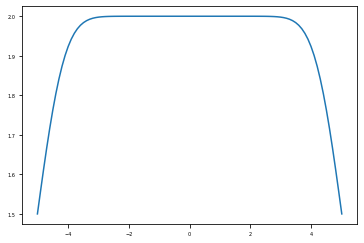

In [93]:
def cov_pprbfn(x1, x2, C0=-5, C1=5, sig2b = 1., sig2w = 1., \
        s20 = 1., intensity = 1.):
    xm = (x1+x2)/2
    
    nonstation = norm.cdf((C1-xm)*(np.sqrt(2*s20)*intensity)) - \
                 norm.cdf((C0-xm)*(np.sqrt(2*s20)*intensity))

    return sig2b + sig2w * np.exp(-s20*intensity**2*((x1-x2)/2)**2)*nonstation
    
    
x = np.linspace(-5,5,100)
plt.plot(x, cov_pprbfn(x, x))
    

Compare empirically

In [94]:
dir_base = '../../'
dir_src = os.path.join(dir_base, 'src/porbnet/')

sys.path.append(dir_src)
import networks_porbnet as networks
import util_porbnet as util

In [95]:
torch.manual_seed(2)
np.random.seed(2) # includes one numpy part
intensity_true = util.Piecewise(breaks = [-5,5], values = [1.])
net = networks.RBFN(dim_in=1, dim_hidden_initial=10, dim_hidden_max=30, dim_out=1, \
                    intensity = intensity_true, s2_0 = 5., \
                    prior_w_sig2 = 1., prior_b_sig2 = 1., \
                    sig2=1e-4, prior_sig2_alpha = None, prior_sig2_beta = None)

x_torch = torch.from_numpy(x).float().reshape(-1,1)


In [96]:
## check prior
y_samp_prior = net.sample_functions_prior(x_torch, n_samp=1000)


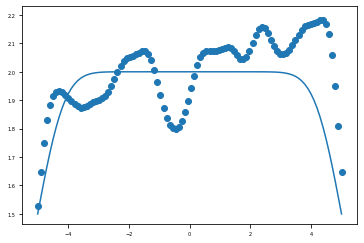

In [97]:
fig, ax = plt.subplots()
ax.scatter(x, torch.var(y_samp_prior, dim=0).detach().numpy())
#ax.set_ylim(0,.05)
ax.plot(x, cov_pprbfn(x, x))

## final figure

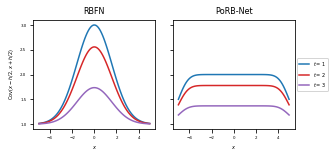

In [106]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams.update({'font.size': 4})
plt.rcParams.update({'legend.fontsize': 5})
plt.rcParams.update({'axes.labelsize': 5})
plt.rcParams.update({'axes.titlesize': 8})

fig, ax = plt.subplots(1,2,figsize=(6,2), sharex=True, sharey=True)

vario_pprbfn = lambda x, h: cov_pprbfn(x-h/2, x+h/2, \
                                       C0=-5, C1=5, sig2b = 1., sig2w = 1., \
                                       s20 = 1., intensity = 1.)

vario_rbfn = lambda x, h: cov_rbfn(x-h/2, x+h/2, \
                                   sig2b=1., sig2w=1., \
                                   sig2c=2., sig2s=1., K=10)

# from williams paper
ax[0].plot(x, vario_rbfn(x, 0), label=r'$t=1$', color='tab:blue')
ax[0].plot(x, vario_rbfn(x, 1), label=r'$t=2$', color='tab:red')
ax[0].plot(x, vario_rbfn(x, 2), label=r'$t=3$', color='tab:purple')
ax[0].set_title('RBFN')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Cov$(x-h/2,x+h/2)$')

# porbnet
ax[1].plot(x, vario_pprbfn(x, 0), label=r'$t=1$', color='tab:blue')
ax[1].plot(x, vario_pprbfn(x, 1), label=r'$t=2$', color='tab:red')
ax[1].plot(x, vario_pprbfn(x, 2), label=r'$t=3$', color='tab:purple')
ax[1].set_title('PoRB-Net')
ax[1].set_xlabel(r'$x$')

box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])


box = ax[1].get_position()
ax[1].set_position([box.x0-.1, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_yticks(np.array([1, 1.5, 2.0, 2.5, 3.0]))

In [107]:
fig.set_size_inches(2.9, 1.5)
fig.tight_layout()

In [108]:
fig.savefig('fig2_PoRB-NET.png', bbox_inches='tight', pad_inches=.01)
fig.savefig('fig2_PoRB-NET.pdf', bbox_inches='tight', pad_inches=.01)